Import dataset from Kaggle

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:45<00:00, 23.4MB/s]
100% 2.29G/2.29G [01:45<00:00, 23.3MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Import required dependencies

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt


Set required variables

In [5]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE =32
num_classes =1
image_dir = '/content/chest_xray/train'

In [6]:
classes = os.listdir(image_dir)
print(classes)

['NORMAL', 'PNEUMONIA']


Sample images from each class

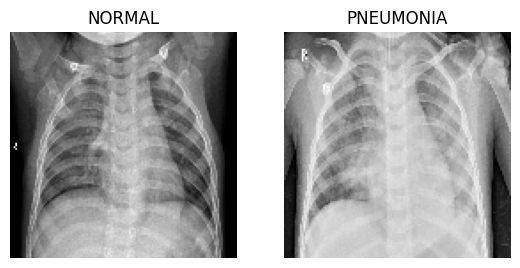

In [7]:
class_dirs = os.listdir(image_dir)
plt.figure(figsize=(10, 10))
for i, cls in enumerate(class_dirs, start=1):
    img_path = os.path.join(image_dir, cls, os.listdir(os.path.join(image_dir, cls))[0])
    img = load_img(img_path, target_size=(128, 128))
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()

Class distribution

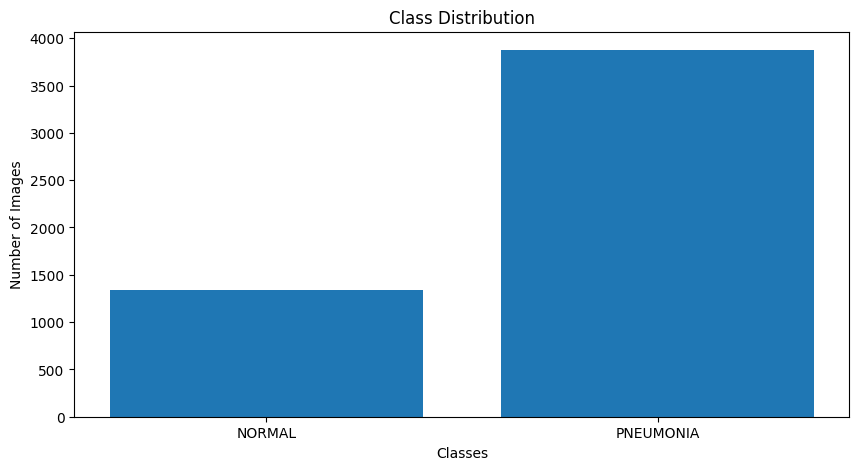

In [8]:
from collections import Counter

# Count images per class
class_counts = Counter()
for cls in classes:
    class_dir = os.path.join(image_dir, cls)
    class_counts[cls] = len(os.listdir(class_dir))

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

Seems the dataset is imbalanced, Data augmentation is required

Create the training dataset

In [9]:
# ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse' #assigns integers as classes
)

Found 5216 images belonging to 2 classes.


In [10]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
class_names = list(train_generator.class_indices.keys())
class_names

['NORMAL', 'PNEUMONIA']

Create test and validation dataset

In [12]:
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_test_datagen.flow_from_directory(
    '/content/chest_xray/val',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/chest_xray/test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    shuffle = False, # to keep the order of images consistent between y_true and y_pred, is required for model evaluation
    class_mode='sparse'
)


Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Using a Pretrained model VGG16 for training**

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [14]:
# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

In [53]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [54]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23103809 (88.13 MB)
Trainable params: 8389121 (32.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [57]:
history = model.fit(
    train_generator,
    #steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    #validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
163/163 [==============================] - 132s 800ms/step - loss: 0.2550 - accuracy: 0.8886 - val_loss: 0.2646 - val_accuracy: 0.9375
Epoch 2/10
163/163 [==============================] - 132s 809ms/step - loss: 0.1856 - accuracy: 0.9229 - val_loss: 0.2108 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 130s 797ms/step - loss: 0.1639 - accuracy: 0.9329 - val_loss: 0.2574 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 129s 793ms/step - loss: 0.1555 - accuracy: 0.9388 - val_loss: 0.2107 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 131s 798ms/step - loss: 0.1550 - accuracy: 0.9350 - val_loss: 0.2193 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 129s 793ms/step - loss: 0.1375 - accuracy: 0.9484 - val_loss: 0.3812 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 129s 791ms/step - loss: 0.1366 - accuracy: 0.9456 - val_loss: 0.2135 -

Accuracy on test data

**Model Evaluation**

In [58]:
print(model.evaluate(test_generator))

20/20 [==============================] - 7s 311ms/step - loss: 0.2141 - accuracy: 0.9103
[0.21409466862678528, 0.9102563858032227]


91% accuracy on the test dataset

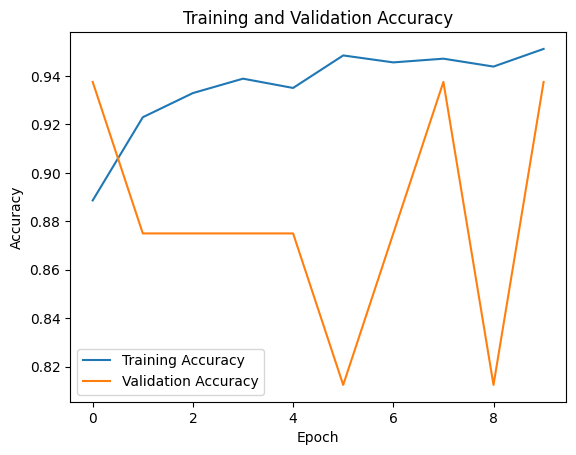

In [59]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Validation accuracy is not that stable due to very few images data in validation dataset

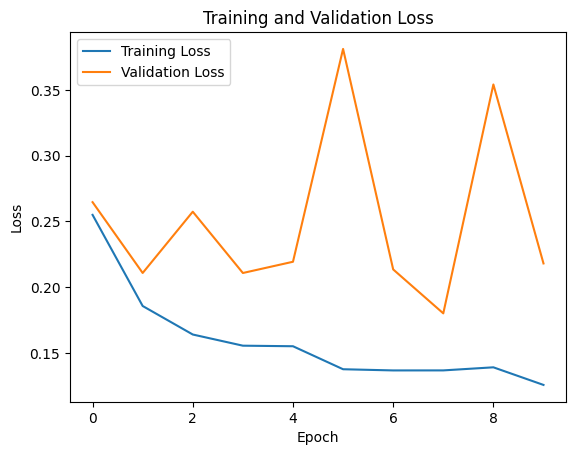

In [60]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Prediction on the test data

In [61]:
y_pred_probs = model.predict(test_generator)

20/20 [==============================] - 6s 265ms/step


In [62]:
y_pred_classes = (y_pred_probs > 0.5).astype(int)
y_pred = y_pred_classes.flatten()

print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [63]:
y_true = test_generator.classes
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

Precision, Recall, F1 score

In [64]:
precision = precision_score(y_true, y_pred)

recall = recall_score(y_true, y_pred)

f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9053398058252428
Recall: 0.9564102564102565
F1 Score: 0.9301745635910225


In [65]:
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[195  39]
 [ 17 373]]


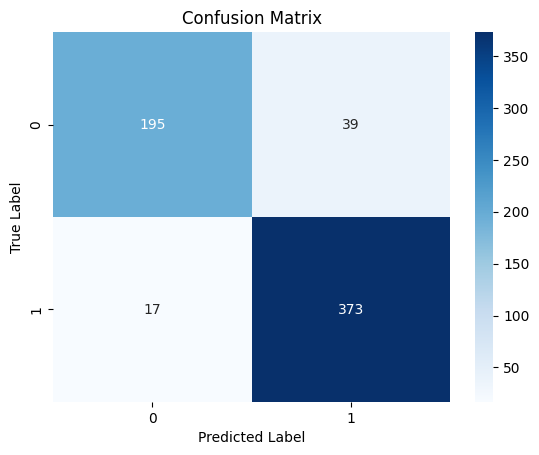

In [66]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Save the trained model

In [67]:
model.save("img_clf_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
